In [38]:
import pandas as pd
import numpy as np
from typing import Dict, List
from tqdm.notebook import tqdm

# Embedding algorithm essentials
from gensim.models import Word2Vec

In [39]:
df_db_tracks = pd.read_csv('../dataset/tracks.csv')
df_db_tracks['id_artists'] = df_db_tracks['id_artists'].apply(lambda x: x[1:-1].strip().replace("'", "").split(','))
df_db_tracks.head(2)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,0,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.263,0,-22.136,1,0.957,0.797,0.000,0.148,0.655,102.009,1


In [40]:
df_db_tracks.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [41]:
df_db_artists = pd.read_csv('../dataset/artists.csv')
df_db_artists['genres'] = df_db_artists['genres'].apply(lambda x: x[1:-1].strip().replace("'", "").split(','))
df_db_artists.tail(5)

,id,followers,genres,name,popularity
1162090,3cOzi726Iav1toV2LRVEjp,4831.0,[black comedy],Ali Siddiq,34
1162091,6LogY6VMM3jgAE6fPzXeMl,46.0,[],Rodney Laney,2
1162092,19boQkDEIay9GaVAWkUhTa,257.0,[],Blake Wexler,10
1162093,5nvjpU3Y7L6Hpe54QuvDjy,2357.0,[black comedy],Donnell Rawlings,15
1162094,2bP2cNhNBdKXHC6AnqgyVp,40.0,[new comedy],Gabe Kea,8


Join Tracks table with artists table in order to bring the Genre information and Artist popularity, in the track schema

In [42]:
artist_information = df_db_artists.set_index('id').to_dict(orient='index')

In [43]:
def get_genres_for_artists(id_artists: List[str]) -> List[str]:
    genres = []
    for artist_id in id_artists:
        genres += artist_information[artist_id]['genres'] if artist_id in artist_information.keys() else []
    return list(set(genres))


def get_popularity_for_artists(id_artists: List[str]) -> List[int]:
    popularity = []
    for artist_id in id_artists:
        popularity += [artist_information[artist_id]['popularity']] if artist_id in artist_information.keys() else []
    return popularity


def process_genre(genre: str) -> str:
    return genre.strip()

In [44]:
df_db_tracks['genres'] = df_db_tracks['id_artists'].apply(lambda x: get_genres_for_artists(x))

In [45]:
# genres mix
df_db_tracks_genres = df_db_tracks[['id', 'genres']]
genre_mix = df_db_tracks_genres.to_dict('records')
genre_mix = [[process_genre(g.strip()) for g in track['genres']] for track in genre_mix]

In [52]:
genre_list = [genre for genre_temp_list in genre_mix for genre in genre_temp_list if genre != '']
genre_list = list(set(genre_list))
len(genre_list)

4514

#### Genre Graph Representation

In [9]:
graph = {}

genre_mix_weight = 1

for track_genres in tqdm(genre_mix):
    # O(n^2) complexity for artists
    for genre_root in track_genres:
        for genre_edge in track_genres:
            if genre_root == genre_edge: continue
            
            if genre_root not in graph:
                graph[genre_root] = {}
            
            if genre_edge not in graph[genre_root]:
                graph[genre_root][genre_edge] = 0
            
            graph[genre_root][genre_edge] += genre_mix_weight

  0%|          | 0/586672 [00:00<?, ?it/s]

In [16]:
from pecanpy import pecanpy
from pecanpy.graph import AdjlstGraph

# load graph object using SparseOTF mode
g = pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)

adjl_graph = AdjlstGraph()
for genre in graph:
    adjl_graph.add_node(genre)
    for genre_to in graph[genre]:
        adjl_graph.add_node(genre_to)
        adjl_graph.add_edge(genre, genre_to, weight=graph[genre][genre_to], directed=False)


g = pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)
g = g.from_adjlst_graph(adjl_graph)

In [17]:
# generate random walks
walks = g.simulate_walks(num_walks=100, walk_length=10)

In [18]:
print("Total number of graph nodes:", g.num_nodes)
print("Total number of graph edges:", g.num_edges)

Total number of graph nodes: 4284
Total number of graph edges: 74782


In [19]:
# use random walks to train embeddings
mdl = Word2Vec(walks, vector_size=4, window=2, min_count=0, sg=1, workers=4, epochs=10)

In [3]:
for s in mdl.wv.most_similar('techno', topn = 10):
    print(s)

('jazz house', 0.9999514222145081)
('classic house', 0.9998214244842529)
('microhouse', 0.9996740221977234)
('uk hip hop', 0.999575674533844)
('chicago house', 0.9995716214179993)
('spanish electronic', 0.9994437098503113)
('afroswing', 0.999343991279602)
('float house', 0.9992362856864929)
('colombian electronic', 0.9992113709449768)
('bass music', 0.9990977048873901)


In [35]:
sample_genres = [
    "rock",
    "techno",
    "pop",
    "dance pop",
    "jazz",
    "cool jazz",
    "modern swing",
    "chicago house",
    "house",
    "deep house",
    "bass house",
    "future bass",
    "drill",
    "rap",
    "r&b",
    "teen pop",
    "tech house",
    "electro house",
    "ambient",
    "hard rock",
    "country"
]

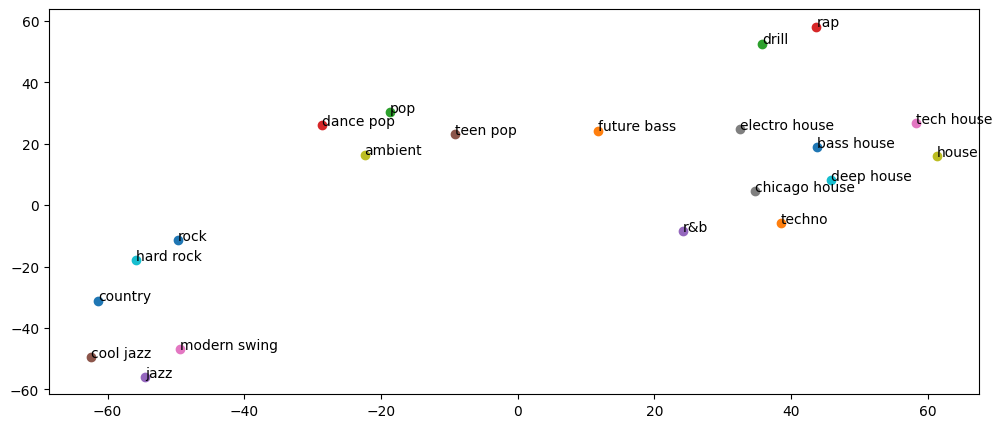

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tokens = []
labels = []

for name in sample_genres:
    labels.append(name)
    tokens.append(mdl.wv.get_vector(name))

tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2000, random_state=13)
new_values = tsne_model.fit_transform(np.array(tokens))

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
fig, ax = plt.subplots(figsize=(12,5)) 
for i in range(len(x)):
    ax.scatter(x[i], y[i])
    
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

plt.show()

In [17]:
mdl.save("../models/genre_embeddings_v5.model")

In [1]:
import gensim

mdl = gensim.models.Word2Vec.load("../models/genre_embeddings_v4.model")

## Embeddings from BLMs

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

#### Construct embedding corpus

In [75]:
#Encoding:
all_genres_embeddings = model.encode(genre_list)
all_genres_embeddings.shape

(4514, 768)

### Dimensionality Reduction

In [76]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=16, random_state=13)
all_genres_embeddings = pca_model.fit_transform(all_genres_embeddings)

In [77]:
all_genres_embeddings.shape

(4514, 16)

### Scale in 0-1 range

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

all_genres_embeddings = scaler.fit_transform(all_genres_embeddings)

### Store

In [79]:
embedding_corpus = {}

for i, genre in enumerate(genre_list):
    embedding_corpus[genre] = all_genres_embeddings[i]

In [85]:
np.save('../models/genre_embeddings_bert_v1.npy', embedding_corpus)

#### Example

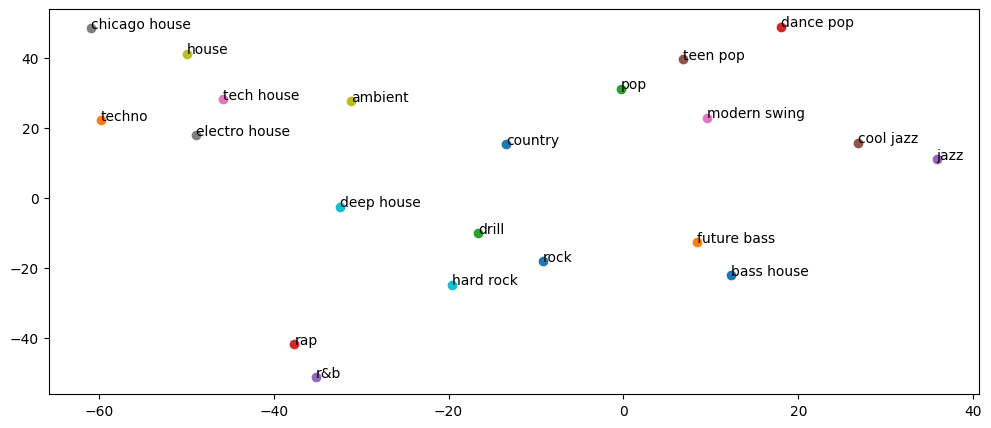

In [80]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tokens = []
labels = []

for i, name in enumerate(sample_genres):
    labels.append(name)
    tokens.append(embedding_corpus[name])

tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2000, random_state=13, metric='cosine')
new_values = tsne_model.fit_transform(np.array(tokens))

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
fig, ax = plt.subplots(figsize=(12,5)) 
for i in range(len(x)):
    ax.scatter(x[i], y[i])
    
for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

plt.show()